In [1]:
import pandas as pd
import numpy as np
from os import system
import graphviz
import matplotlib
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
plt.style.use('seaborn-deep')
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15

In [3]:
filename = "./data/Chicago_Crimes_2001_2018.csv"
tp = pd.read_csv(filename, header=0, iterator=True, chunksize=10000)
input_data = pd.concat(tp, ignore_index=True) 
df = pd.DataFrame(input_data)

In [4]:
# convert dates to pandas datetime format
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %I:%M:%S %p')
# set index to be the date 
df.index = pd.DatetimeIndex(df.Date)

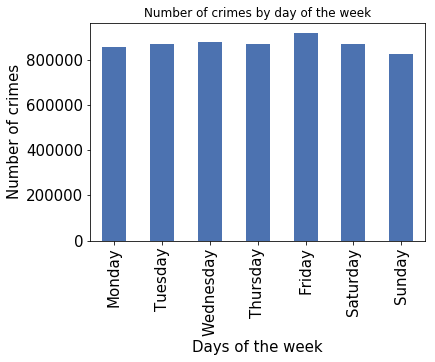

In [5]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby([df.index.dayofweek]).size().plot(kind='bar')
plt.xlabel('Days of the week')
plt.xticks(np.arange(7), days)
plt.ylabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

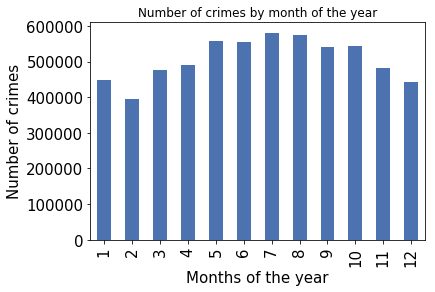

In [6]:
df.groupby([df.index.month]).size().plot(kind='bar')
plt.xlabel('Months of the year')
plt.ylabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

In [7]:
loc_crime  = list(df['Location Description'].value_counts()[20:].index)
desc_crime = list(df['Description'].value_counts()[20:].index)


df.loc[df['Location Description'].isin(loc_crime) , df.columns=='Location Description'] = 'OTHER'
df.loc[df['Description'].isin(desc_crime) , df.columns=='Description'] = 'OTHER'

# we convert the 3 columns into Categorical data
df['Primary Type']         = pd.Categorical(df['Primary Type'])
df['Location Description'] = pd.Categorical(df['Location Description'])
df['Description']          = pd.Categorical(df['Description'])

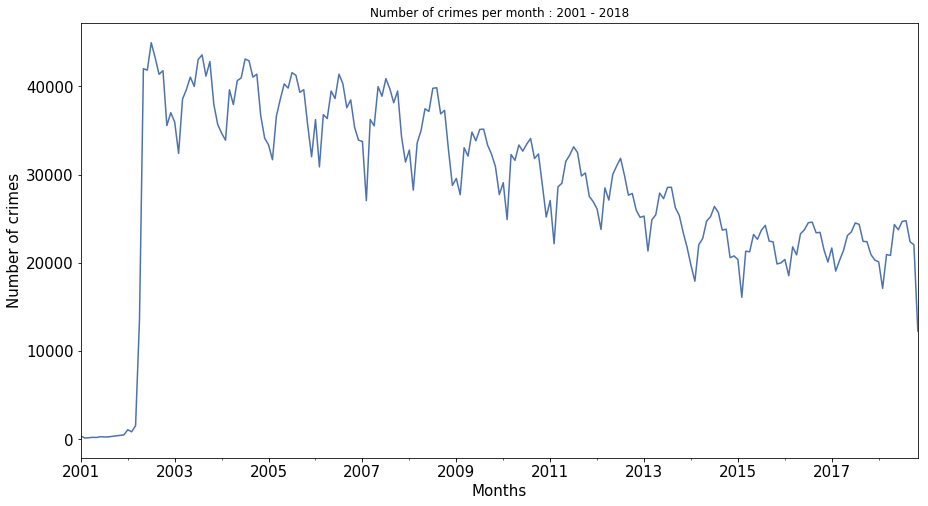

In [8]:
plt.figure(figsize=(15,8))
df.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month : 2001 - 2018')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()


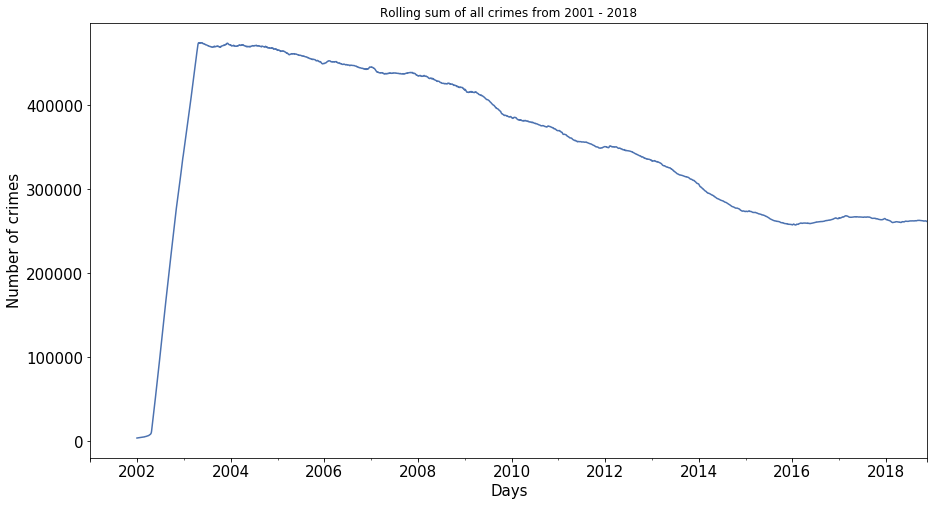

In [9]:
plt.figure(figsize=(15,8))
df.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2001 - 2018')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

In [10]:
df_crime_date = df.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=df.index.date, fill_value=0)
df_crime_date.index = pd.DatetimeIndex(df_crime_date.index)
fig = df_crime_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

In [11]:
import folium
c_map = folium.Map(location=[41.864073,-87.706819], zoom_start=10, tiles="Stamen Terrain")
c_map

In [12]:
locations = df.groupby('Community Area').first()
new_locations = locations.loc[:, ['Latitude', 'Longitude', 'Location Description', 'Block', 'Arrest']]
new_locations.head()

,Latitude,Longitude,Location Description,Block,Arrest
Community Area,,,,,
0.0,41.970515,-87.836651,OTHER,050XX N CUMBERLAND AVE,False
1.0,42.015277,-87.683162,APARTMENT,073XX N HOYNE AVE,False
2.0,41.983747,-87.690677,APARTMENT,056XX N ARTESIAN AVE,False
3.0,41.955027,-87.649864,RESIDENCE,040XX N CLARENDON AVE,False
4.0,41.972571,-87.688892,APARTMENT,050XX N WESTERN AVE,False


In [13]:
popup_df = """Community Index : {}<br
                Arrest : {}<br>
                Location Description : {}<br>"""

for i in range(len(new_locations)):
    lat = new_locations.iloc[i][0]
    long = new_locations.iloc[i][1]
    
    popup_df = popup_df.format(new_locations.index[i],
                               new_locations.iloc[i][-1],
                               new_locations.iloc[i][-2]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_df, fill = True).add_to(c_map)
    
    

In [14]:
c_map

In [15]:
# Scatter plot of all crimes in the dataset according to location per District
# create a dataframe with Homicide as the only crime

df_homicide = df[df['Primary Type']=='HOMICIDE']
df_homicide = df_homicide.loc[(df_homicide['X Coordinate']!=0)]
sns.lmplot('X Coordinate',
           'Y Coordinate',
           data=df_homicide[:],
           fit_reg=False, 
           hue="District", 
           palette='Dark2',
           size=15,
           ci=2,
           scatter_kws={"marker": "D", 
                        "s": 8}) 
ax = plt.gca()
ax.set_title("All Homicides (2001-2018) per District")


Text(0.5,1,'All Homicides (2001-2018) per District')